# Visualizing Text Data

What makes text data so difficult to visualize?


The unstructured nature of text data makes it much more difficult to analyze.  Because it often takes a lot of preprocessing to visualize text data, we'll focus on talking through these examples rather than writing code.

In this lecture, we're going to focus on analyzing reviews of a few fancy European restaurants.  What do people like?  What are they complaing about?  How can we figure that out?

In [1]:
import pandas as pd

df = pd.read_csv('assets/European Restaurant Reviews.csv')

df.head()

,Country,Restaurant Name,Sentiment,Review Title,Review Date,Review
0,France,The Frog at Bercy Village,Negative,Rude manager,May 2024 •,The manager became agressive when I said the c...
1,France,The Frog at Bercy Village,Negative,A big disappointment,Feb 2024 •,"I ordered a beef fillet ask to be done medium,..."
2,France,The Frog at Bercy Village,Negative,Pretty Place with Bland Food,Nov 2023 •,"This is an attractive venue with welcoming, al..."
3,France,The Frog at Bercy Village,Negative,Great service and wine but inedible food,Mar 2023 •,Sadly I used the high TripAdvisor rating too ...
4,France,The Frog at Bercy Village,Negative,Avoid- Worst meal in Rome - possibly ever,Nov 2022 •,From the start this meal was bad- especially g...


## What are some relationships we might try to visualize using this data?

### We can use a word clouds:

Positive Review Titles


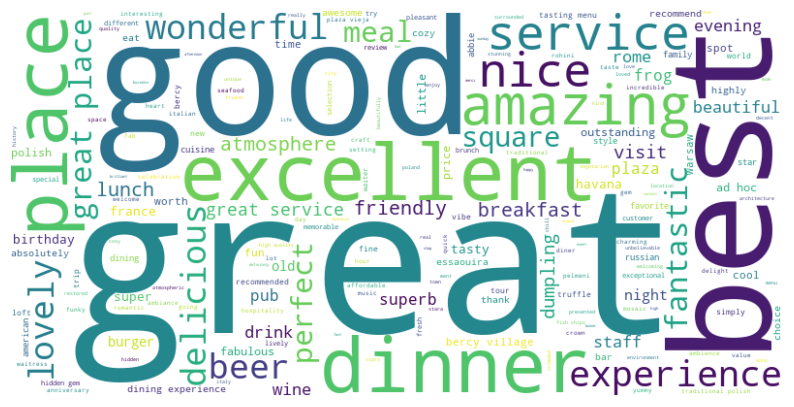

Negative Review Titles


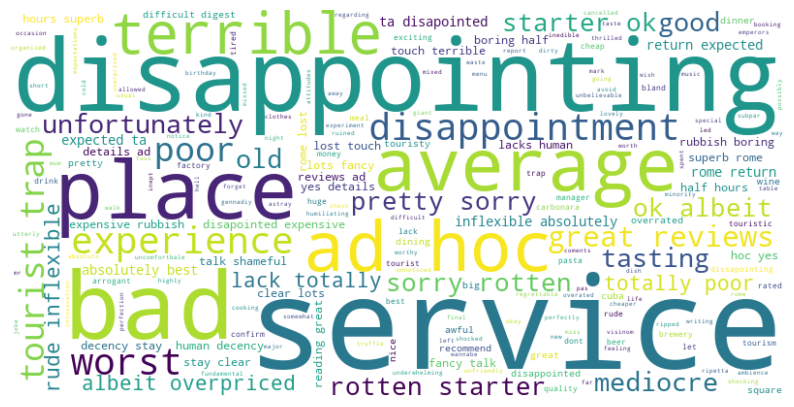

In [2]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sklearn_stop_words

# Define additional stopwords to remove
additional_stopwords = {'food', 'restaurant'}

# Separate positive and negative reviews
positive_reviews = ' '.join(df[df['Sentiment'] == 'Positive']['Review Title'].astype(str))
negative_reviews = ' '.join(df[df['Sentiment'] == 'Negative']['Review Title'].astype(str))

# Tokenize the words
postive_words = positive_reviews.lower().split()
    
# Remove punctuation and stopwords (including additional stopwords)
postive_words = [word.strip(string.punctuation) for word in postive_words if word.isalnum() and word not in sklearn_stop_words and word not in additional_stopwords]
    
# Generate the word cloud
print('Positive Review Titles')
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(' '.join(postive_words))
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#Negative reviews
negative_words = negative_reviews.lower().split()
    
# Remove punctuation and stopwords (including additional stopwords)
negative_words = [word.strip(string.punctuation) for word in negative_words if word.isalnum() and word not in sklearn_stop_words and word not in additional_stopwords]
    
# Generate the word cloud
print('Negative Review Titles')
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(' '.join(negative_words))
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


What are some positive aspects of word clouds?  What are some negatives?

### We can look at word frequencies:

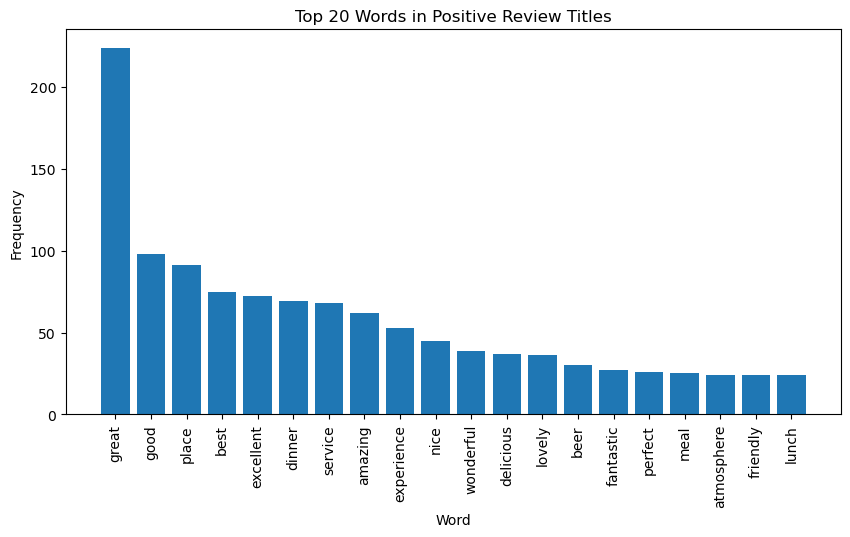

In [3]:
positive_word_freq = Counter(postive_words)
positive_common_words = positive_word_freq.most_common(20)
    
# Convert to DataFrame for plotting
positive_freq_df = pd.DataFrame(positive_common_words, columns=['Word', 'Frequency'])
    
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(positive_freq_df['Word'], positive_freq_df['Frequency'])
ax.set_title(f'Top 20 Words in Positive Review Titles')
ax.set_xlabel('Word')
ax.set_ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

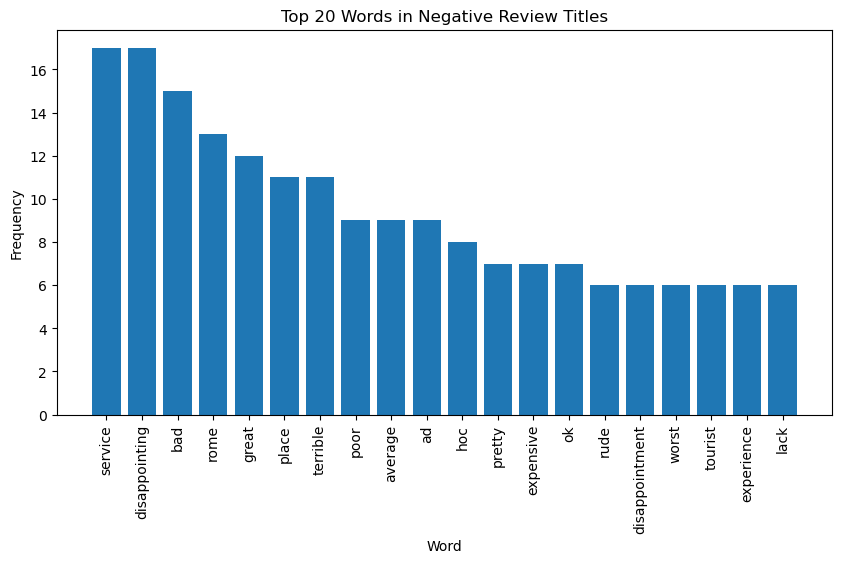

In [4]:
negative_word_freq = Counter(negative_words)
negative_common_words = negative_word_freq.most_common(20)
    
# Convert to DataFrame for plotting
negative_freq_df = pd.DataFrame(negative_common_words, columns=['Word', 'Frequency'])
    
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(negative_freq_df['Word'], negative_freq_df['Frequency'])
ax.set_title(f'Top 20 Words in Negative Review Titles')
ax.set_xlabel('Word')
ax.set_ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

## Sentiment

Another way to look at the data is to see how different words factor into the overall sentiment of a review.  There are different ways to do this, but one way is by using the textblob library (Python has tons of NLP libraries) to compute the sentiment of each review.  Sentiment can be positive (a positive value), negative (a negative value) or neutral (a value at or near 0).  

Interestingly, the sentiment calculated by textblob doesn't align perfectly (though it does generally match up) with the positive/negative label given in the data.  

Let's look at the sentiment vs subjectivity color coded by the sentiment label in the dataset.


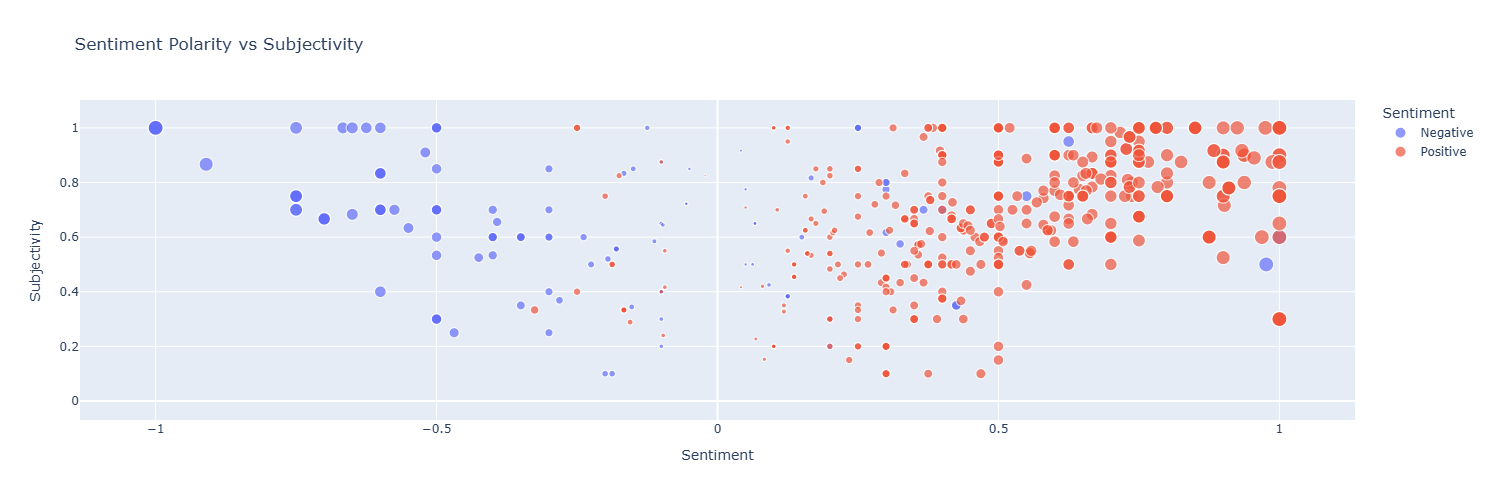

In [5]:
#%pip install textblob
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from textblob import TextBlob
import plotly.express as px

# Sentiment calculations
df['calc_sentiment'] = df['Review Title'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['subjectivity'] = df['Review Title'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
df['abs_sentiment'] = df['calc_sentiment'].abs()

# Optional: Make sentiment a category to suppress warning
df['Sentiment'] = df['Sentiment'].astype(str)

# Plot
fig = px.scatter(
    df, 
    x='calc_sentiment', 
    y='subjectivity', 
    hover_data=['Review Title'],
    color='Sentiment',
    size='abs_sentiment',
    size_max=15,
    title='Sentiment Polarity vs Subjectivity',
    hover_name='Restaurant Name',
    labels={'sentiment': 'Sentiment Polarity', 'subjectivity': 'Subjectivity'}
)

fig.update_layout(xaxis_title='Sentiment', height=500)
fig.show()



Now lets color code by restaruant.


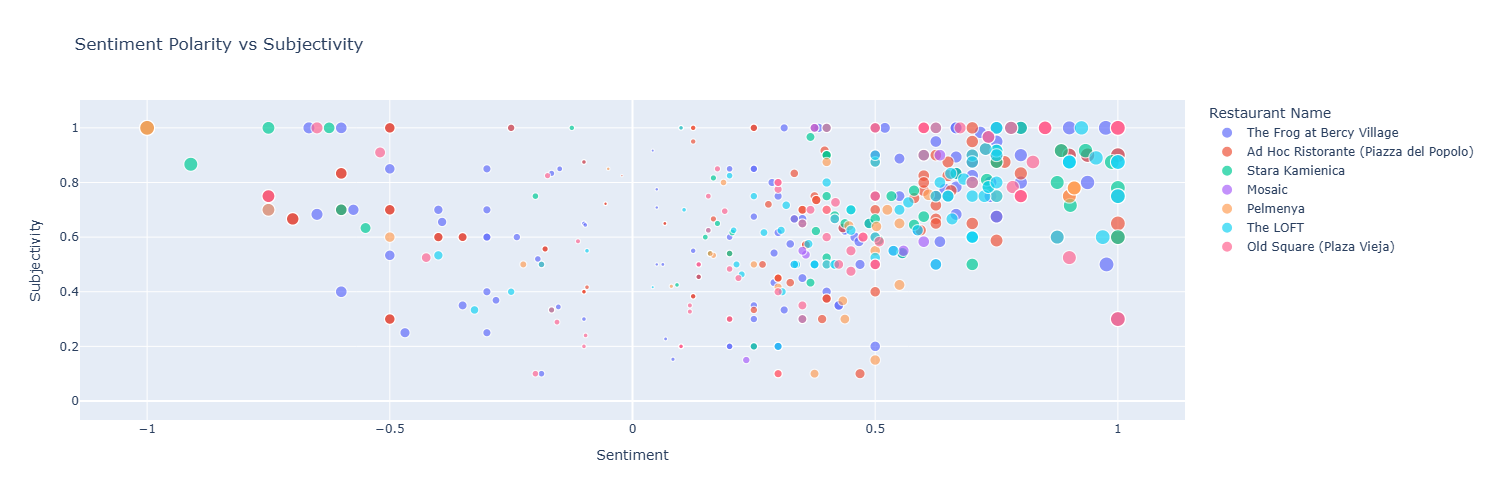

In [6]:
fig = px.scatter(df, x='calc_sentiment', y='subjectivity', 
                 hover_data=['Review Title'],
                 color='Restaurant Name',
                 size='abs_sentiment',
                 size_max = 15,
                 title='Sentiment Polarity vs Subjectivity',
                 hover_name = 'Restaurant Name',
                 labels={'sentiment': 'Sentiment Polarity', 'subjectivity': 'Subjectivity'})

fig.update_layout(xaxis_title = 'Sentiment', height=500)
fig.show()

Let's look at the range of sentiment associated with each word.

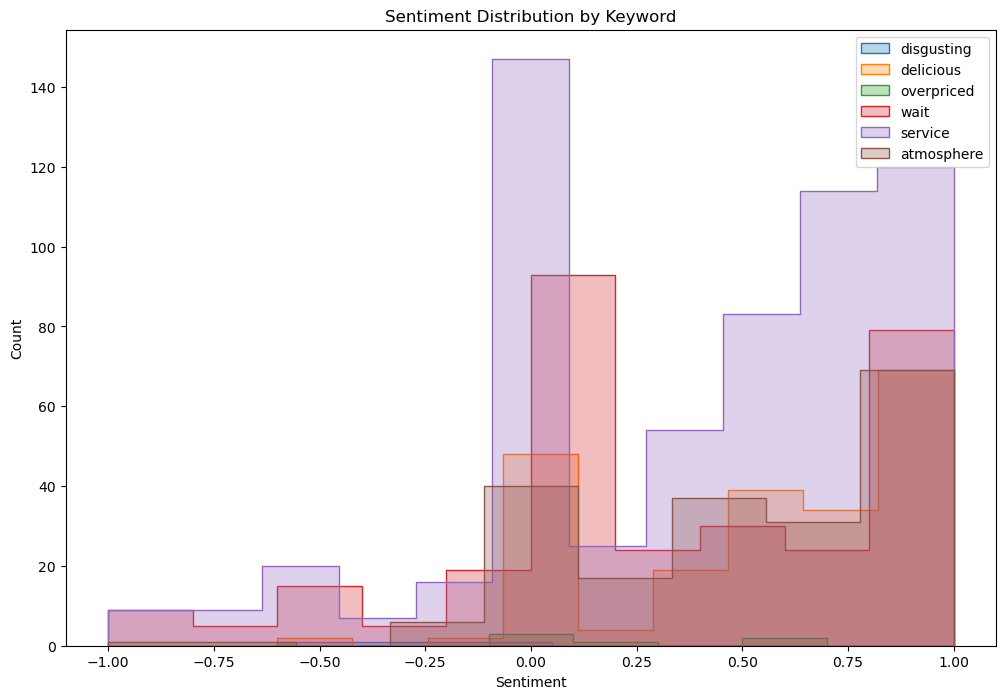

In [7]:
import seaborn as sns

keywords = ["disgusting", "delicious", "overpriced", "wait", "service", "atmosphere"]

# Filter reviews based on the presence of keywords and compute sentiment for each keyword
sentiments = {}
for keyword in keywords:
    sentiments[keyword] = df[df['Review'].str.contains(keyword, case=False, na=False)]['calc_sentiment']

# Plot
plt.figure(figsize=(12, 8))
for keyword, sentiment in sentiments.items():
    sns.histplot(sentiment, label=keyword, element='step', alpha=.3)
    
plt.title('Sentiment Distribution by Keyword')
plt.xlabel('Sentiment')
plt.legend()

### Review Metadata

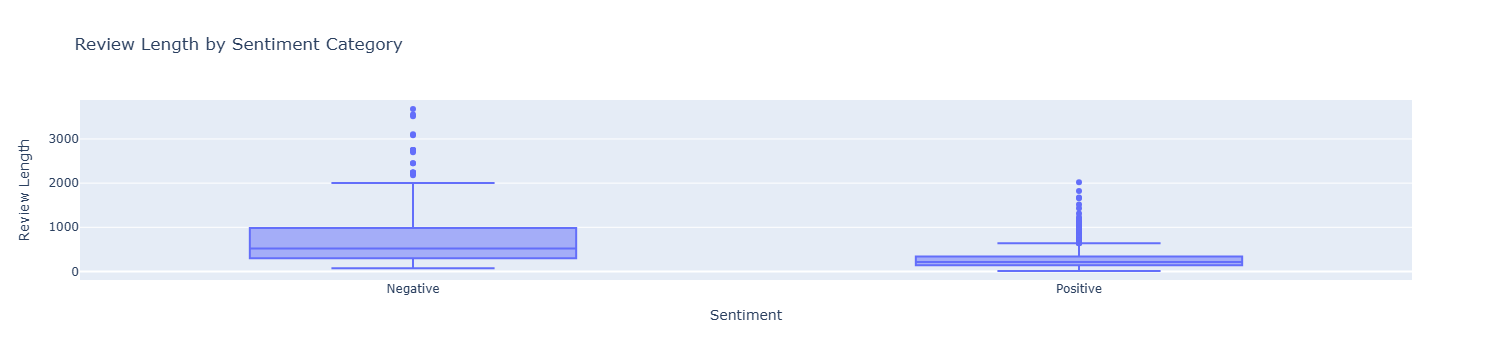

In [8]:
df['review_length'] = df['Review'].str.len()


# Create the box plot
fig = px.box(df, x='Sentiment', y='review_length', title='Review Length by Sentiment Category',
             labels={'review_length': 'Review Length'})

# Show the plot
fig.show()

# Cosine Similarity
 
Turn each text into a vector of word counts. 
Then measure how close the two vectors point using the cosine of the angle between them.

$\displaystyle \mathrm{cosine\_sim}(A,B) = \frac{A \cdot B}{\lVert A\rVert\,\lVert B\rVert}$


- $A \cdot B$: dot product (sum of element‑wise products)  
- $\lVert A\rVert$: Euclidean norm (length) of vector $A$  
- $\lVert B\rVert$: Euclidean norm (length) of vector $B$



### Visual Intuition

      ^ 
      |        B
      |       /
      |      /
      |     / ) θ
      |    / 
      |   /
      |  / A
      +----------------->



- If θ = 0° (vectors point the same way), cosine similarity = 1  
- If θ = 90° (orthogonal), cosine similarity = 0  
- If θ = 180° (opposite), cosine similarity = –1 (rare in bag‑of‑words)

---

### Mini Text Example

Two short “documents”:

- **T1:** “the cat sat on the mat”  
- **T2:** “the dog lay on the rug”

**Step 1 – Vocabulary:**  
`[the, on, cat, sat, mat, dog, lay, rug]`

**Step 2 – Count vectors:**  

| Word | T1 | T2 |
|------|----|----|
| the  |  2 |  2 |
| on   |  1 |  1 |
| cat  |  1 |  0 |
| sat  |  1 |  0 |
| mat  |  1 |  0 |
| dog  |  0 |  1 |
| lay  |  0 |  1 |
| rug  |  0 |  1 |




- **Dot product:**  

| Word | T1 | T2 | Product (T1 × T2) |
| ---- | -- | -- | ----------------- |
| the  | 2  | 2  | 4                 |
| on   | 1  | 1  | 1                 |
| cat  | 1  | 0  | 0                 |
| sat  | 1  | 0  | 0                 |
| mat  | 1  | 0  | 0                 |
| dog  | 0  | 1  | 0                 |
| lay  | 0  | 1  | 0                 |
| rug  | 0  | 1  | 0                 |
| total|    |    | 5                 |    

- **Vector norms:**  
  $$
    \lVert T_1 \rVert
    = \sqrt{2^2 + 1^2 + 1^2 + 1^2 + 1^2}
    = \sqrt{8}
  $$
  $$
    \lVert T_2 \rVert
    = \sqrt{2^2 + 1^2 + 1^2 + 1^2 + 1^2}
    = \sqrt{8}
  $$

- **Cosine similarity:**  
  $$
    \operatorname{cosine\_sim}(T_1, T_2)
    = \frac{T_1 \cdot T_2}{\lVert T_1 \rVert \;\lVert T_2 \rVert}
    = \frac{5}{\sqrt{8}\;\sqrt{8}}
    = \frac{5}{8}
    = 0.625
  $$


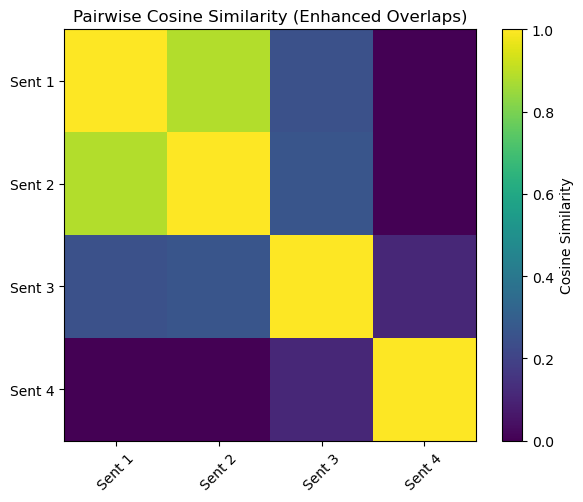

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import re
from collections import Counter

# Updated sentences with more overlap
sentences = [
    "The cat sat on the mat.",
    "The dog sat on the mat next to the cat.",
    "Quantum physics explores the behavior of subatomic particles.",
    "I love exploring particle behavior when eating sushi with friends."
]

# Tokenize and count words using regex (avoids extra NLTK/TextBlob dependencies)
def wc_vector(text, vocab):
    tokens = re.findall(r"\b\w+\b", text.lower())
    wc = Counter(tokens)
    return np.array([wc.get(word, 0) for word in vocab])

# Build a sorted global vocabulary
vocab = set()
for s in sentences:
    vocab.update(re.findall(r"\b\w+\b", s.lower()))
vocab = sorted(vocab)

# Compute word‑count vectors for each sentence
vectors = [wc_vector(s, vocab) for s in sentences]

# Cosine‐similarity function
def cosine_sim(a, b):
    dot = np.dot(a, b)
    na = np.linalg.norm(a)
    nb = np.linalg.norm(b)
    return dot / (na * nb) if na and nb else 0.0

# Build the full pairwise similarity matrix
N = len(vectors)
sim_matrix = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        sim_matrix[i, j] = cosine_sim(vectors[i], vectors[j])

# Plotting the similarity matrix as a heatmap
plt.figure(figsize=(6, 5))
plt.imshow(sim_matrix, interpolation='nearest')
plt.colorbar(label='Cosine Similarity')

labels = [f"Sent {i+1}" for i in range(N)]
plt.xticks(range(N), labels, rotation=45)
plt.yticks(range(N), labels)

plt.title("Pairwise Cosine Similarity (Enhanced Overlaps)")
plt.tight_layout()
plt.show()
